In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pytz
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from geopy import distance

## Old Method

In [2]:
# Temporal hotspot
def is_win_thigh(win, ff):
    # "win" is of type numpy.ndarray
    c_ii = (len(win)-1)//2
    c = win[c_ii]
    m = np.maximum(win[:c_ii].max(), win[c_ii+1:].max())
    r = c >= (1 + ff)*m
    return r


def is_win_tlow(win, ff):
    # "win" is of type numpy.ndarray
    c_ii = (len(win)-1)//2
    c = win[c_ii]
    m = np.minimum(win[:c_ii].min(), win[c_ii+1:].min())
    r = c <= ff*m
    return r


In [3]:
def get_hotspots(data, sensor, params, locs):

    # get data and distances; data is expected to be a pandas.Series,
    # not pandas.DataFrame, containing only one column (either pm25 or
    # pm10)
    df = data.unstack(level=0)
    distances = pd.read_csv('/scratch/ab9738/epod-nyu-delhi-pollution/data/combined_distances.csv', index_col=[0])

    # select only the locations that are in the data
    distances = distances.loc[df.columns, df.columns]

    # invalidate diagonal entries so that sensor M does not get
    # counted in the M's radius
    distances[distances == 0] = np.nan

    # res: three digit entries 'abc' or NaN, where a/b/c = 1 or 9
    #
    # a == 9 => thigh, a == 1 => tlow
    # b == 9 => shigh, b == 1 => slow
    # c == 9 => jhigh, c == 1 => jlow
    res = pd.DataFrame(index=df.index, columns=df.columns)

    # (1) WINDOW HOTSPOTS

    # **Temporal Window Hotspot**: a timestamp is marked as a temporal
    # window hotspot if the value at that time is greater/lesser than
    # a window (radius "wtr") around it by a threshold fraction "wttf"
    wts = 2*params['wtr'] + 1
    rolling_wt = df.rolling(wts, min_periods=wts, center=True)
    res_win_thigh = rolling_wt.apply(is_win_thigh, raw=True, args=(params['wttf'],))
    res_win_tlow = rolling_wt.apply(is_win_tlow, raw=True, args=(params['wttf'],))
    res[res_win_thigh == 1] = 900
    res[res_win_tlow == 1] = 100

    # **Spatial Window Hotspot**: A location is marked as a
    # spatial window hotspot if, at a given time, the value at
    # that location is greater/lesser than the max of values in a
    # radius ("wsr") around it by a threshold frac "wstf"
    res_win_shigh = pd.DataFrame(index=df.index, columns=df.columns)
    res_win_slow = pd.DataFrame(index=df.index, columns=df.columns)
    for mid in df.columns:
        neighborhood = (distances.loc[mid] <= params['wsr'] * 1000)
        neighborhood_max = df.loc[:,neighborhood].max(axis=1)
        neighborhood_min = df.loc[:,neighborhood].min(axis=1)
        res_win_shigh.loc[:, mid] = (df[mid] > ((1 + params['wstf']) * neighborhood_max))
        res_win_shigh.loc[neighborhood_max.isna() | df[mid].isna(), mid] = np.nan
        res_win_slow.loc[:, mid]  = (df[mid] < (params['wstf'] * neighborhood_min))
        res_win_slow.loc[neighborhood_min.isna() | df[mid].isna(), mid] = np.nan
    res[(res_win_shigh == 1) & res.notna()] += 90
    res[(res_win_shigh == 1) & res.isna()] = 90
    res[(res_win_slow == 1) & res.notna()] += 10
    res[(res_win_slow == 1) & res.isna()] = 10

    # (2) JUMP HOTSPOTS

    # for jumps: first the data is smoothened using a rolling window
    # of radius "jtr", then every timestamp where the change from the
    # previous timestamp is greater/lesser than the threshold "jtv" is
    # marked, and finally a timestamp+location is marked as a hotspot
    # if the change in the values at that location is the
    # highest/lowest in a radius "jsr"
    rolling_j = df.rolling(2*params['jtr'] + 1, min_periods=1, center=True).mean().diff()
    res_jump_high = pd.DataFrame(index=df.index, columns=df.columns)
    res_jump_low = pd.DataFrame(index=df.index, columns=df.columns)
    for mid in df.columns:
        neighborhood = (distances.loc[mid] <= params['jsr'] * 1000)
        neighborhood_max = rolling_j.loc[:,neighborhood].max(axis=1)
        neighborhood_min = rolling_j.loc[:,neighborhood].min(axis=1)
        res_jump_high.loc[:, mid] = (rolling_j[mid] > params['jtv']).to_numpy() &\
        (rolling_j[mid] > neighborhood_max).to_numpy()
        res_jump_high.loc[rolling_j[mid].isna() | neighborhood_max.isna(), mid] = np.nan
        res_jump_low.loc[:, mid] = (rolling_j[mid] < -params['jtv']).to_numpy() &\
        (rolling_j[mid] < neighborhood_min).to_numpy()
        res_jump_low.loc[rolling_j[mid].isna() | neighborhood_min.isna(), mid] = np.nan
    res[(res_jump_high == 1) & res.notna()] += 9
    res[(res_jump_high == 1) & res.isna()] = 9
    res[(res_jump_low == 1) & res.notna()] += 1
    res[(res_jump_low == 1) & res.isna()] = 1
    
    return res

# Main

## Parameters of Data and Hotspots

In [4]:
source = 'combined'
sensor = 'pm25'
res_time = '3H'
res_space = '0'
wtr = 1
wttf = 0.5
wsr = 5.0
wstf = 0.5
jtr = 1
jsr = 5.0
jtv = 100 if sensor == 'pm25' else 200

## Data Loading

In [5]:
filepath_root = '/scratch/ab9738/epod-nyu-delhi-pollution/'
filepath_data_kai = filepath_root+'data/kaiterra/kaiterra_fieldeggid_{}_current_panel.csv'.format(res_time)
filepath_data_gov = filepath_root+'data/govdata/govdata_{}_current.csv'.format(res_time)
filepath_locs_kai = filepath_root+'data/kaiterra/kaiterra_locations.csv'
filepath_locs_gov = filepath_root+'data/govdata/govdata_locations.csv'

locs_kai = pd.read_csv(filepath_locs_kai, index_col=[0])
locs_kai['Type'] = 'Kaiterra'
locs_gov = pd.read_csv(filepath_locs_gov, index_col=[0])
locs_gov['Type'] = 'Govt'
locs = pd.merge(locs_kai, locs_gov, how='outer',\
                on=['Monitor ID', 'Latitude', 'Longitude', 'Location', 'Type'], copy=False)
data_kai = pd.read_csv(filepath_data_kai, index_col=[0,1], parse_dates=True)[sensor]
data_gov = pd.read_csv(filepath_data_gov, index_col=[0,1], parse_dates=True)[sensor]
data = pd.concat([data_kai, data_gov], axis=0, copy=False)

start_dt = data.index.levels[1][0]
end_dt = data.index.levels[1][-1]

if start_dt.tzname != 'IST':
        if start_dt.tzinfo is None:
            start_dt = start_dt.tz_localize('UTC')
        start_dt = start_dt.tz_convert(pytz.FixedOffset(330))
    
if end_dt.tzname != 'IST':
    if end_dt.tzinfo is None: 
        end_dt = end_dt.tz_localize('UTC')
    end_dt = end_dt.tz_convert(pytz.FixedOffset(330))

# now, filter through the start and end dates
data.sort_index(inplace=True)
data = data.loc[(slice(None), slice(start_dt, end_dt))]

## Testing Temporal Hotspot Distributions

In [6]:
df = data.unstack(level=0)
distances = pd.read_csv('/scratch/ab9738/epod-nyu-delhi-pollution/data/combined_distances.csv', index_col=[0])
distances = distances.loc[df.columns, df.columns]
distances[distances == 0] = np.nan

In [7]:
diff_list = []
for col in list(df.columns):
    arr = df[col].dropna().to_numpy()
    diff_arr = np.zeros(len(arr)-1)
    for i in range(len(arr)-1):
        diff_arr[i] = abs(arr[i+1]-arr[i])
    diff_list.append(diff_arr)
    
diff = np.concatenate(diff_list)

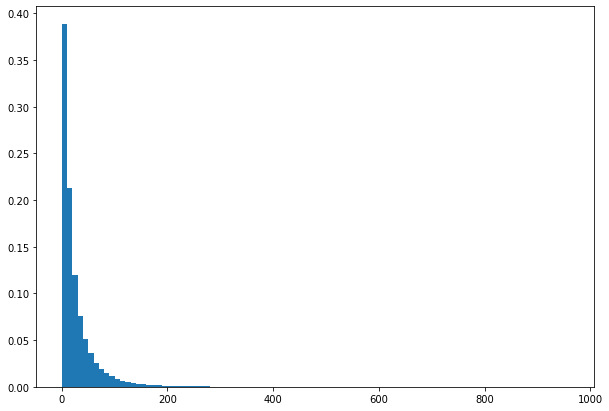

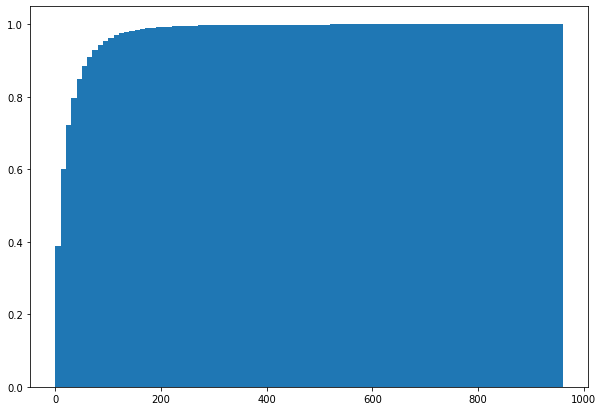

In [8]:
fig, ax = plt.subplots(figsize=(10,7))
stats = plt.hist(diff, weights=np.ones(len(diff))/len(diff), bins=range(int(min(diff)),int(max(diff)) + 10, 10),\
                 cumulative=False)
fig, ax = plt.subplots(figsize=(10,7))
_ = plt.hist(diff, weights=np.ones(len(diff))/len(diff), bins=range(int(min(diff)),int(max(diff)) + 10, 10),\
                 cumulative=True)

In [24]:
stats[0][:15].sum()

0.9827040920587299

In [33]:
(stats[0]*(stats[1]+5)[:-1]).sum()

27.654937456837644

The value of 50 can be considered covering most of the contiguous jumps that happen. Beyond the point 100, jumps are considered rare (less than 5%). We can take 100 as the threshold for defining a hotspot.

## Write code for temporal hotspots

In [25]:
th = 150

In [26]:
def find_temporal_hotspots(arr):
    peak_indices = []
    hotspot_indices = []
    hotspot_windows = []
    plateau = 0
    for i in range(1,len(arr)-1):
        if(arr[i]>arr[i-1] and arr[i]>arr[i+1]):
            peak_indices.append(i)
    for ind in peak_indices:
        left_ind = ind-1
        right_ind = ind+1
        while(left_ind!=-1):
            if(arr[left_ind]<arr[left_ind+1]):
                left_ind -= 1
            else:
                break
        while(right_ind!=len(arr)):
            if(arr[right_ind]<arr[right_ind-1]):
                right_ind += 1
            else:
                break
        if(left_ind==-1):
            left_ind = 0
        if(right_ind==len(arr)):
            right_ind = len(arr)-1
        val_left = arr[left_ind]
        val_right = arr[right_ind]
        val_peak = arr[ind]
        if(val_peak-val_right>th or val_peak-val_left>th):
            hotspot_indices.append(ind)
            hotspot_windows.append((left_ind,right_ind))
        if(abs(val_right-val_left)>th):
            plateau+=1
    return hotspot_indices, hotspot_windows, plateau

In [28]:
num_hsps, num_plts = 0,0
for col in list(df.columns):
    arr = df[col].dropna().to_numpy()
    hsp_ind, hsp_win, plt = find_temporal_hotspots(arr)
    num_hsps += len(hsp_ind)
    num_plts += plt
#     print(col, len(hsp_ind), plt)
print(num_hsps, num_plts)

6033 2739


## Testing Spatial Hotspot Distributions

In [34]:
df = data.unstack(level=0)
distances = pd.read_csv('/scratch/ab9738/epod-nyu-delhi-pollution/data/combined_distances.csv', index_col=[0])
distances = distances.loc[df.columns, df.columns]
distances[distances == 0] = np.nan

In [ ]:
for mid in df.columns:
    neighborhood = (distances.loc[mid] <= params['wsr'] * 1000)
    neighborhood_max = df.loc[:,neighborhood].max(axis=1)
    neighborhood_min = df.loc[:,neighborhood].min(axis=1)
    res_win_shigh.loc[:, mid] = (df[mid] > ((1 + params['wstf']) * neighborhood_max))
    res_win_shigh.loc[neighborhood_max.isna() | df[mid].isna(), mid] = np.nan
    res_win_slow.loc[:, mid]  = (df[mid] < (params['wstf'] * neighborhood_min))
    res_win_slow.loc[neighborhood_min.isna() | df[mid].isna(), mid] = np.nan

In [37]:
for col in df.columns:
    list(distances.loc[col].sort_values().index)[-1]

field_egg_id
498F                      1671.0
DF07                      2026.0
NehruNagar_DPCC           2557.0
CRRIMathuraRoad_IMD       2790.0
A9BE                      2793.0
OkhlaPhase2_DPCC          2951.0
Sirifort_CPCB             2988.0
4BE7                      3130.0
56C3                      3170.0
E1F8                      3255.0
E47A                      3799.0
D804                      3923.0
JNS_DPCC                  4065.0
BFDC                      4091.0
3ACF                      4271.0
BB4A                      5151.0
E8E4                      5220.0
97D7                      5260.0
LodhiRoad_IMD             5479.0
DKSSR_DPCC                5489.0
SriAurobindoMarg_DPCC     5666.0
2E9C                      5684.0
1FD7                      5806.0
EAC8                      5829.0
RKPuram_DPCC              6107.0
MDCNS_DPCC                7369.0
91B8                      7521.0
603A                      8483.0
CBC7                      8573.0
20CA                      8916

In [38]:
df

field_egg_id,113E,1FD7,20CA,2E9C,3ACF,498F,4BE7,56C3,5D7A,603A,...,Pusa_DPCC,Pusa_IMD,RKPuram_DPCC,Rohini_DPCC,Shadipur_CPCB,Sirifort_CPCB,SoniaVihar_DPCC,SriAurobindoMarg_DPCC,VivekVihar_DPCC,Wazirpur_DPCC
timestamp_round,,,,,,,,,,,,,,,,,,,,,
2018-05-01 00:00:00+05:30,NaN,NaN,NaN,NaN,NaN,59.194444,NaN,NaN,49.082090,NaN,...,NaN,38.84,75.00,67.00,45.70,NaN,69.89,NaN,60.33,78.33
2018-05-01 03:00:00+05:30,NaN,NaN,NaN,NaN,NaN,60.111111,NaN,NaN,37.340206,NaN,...,NaN,37.62,39.67,53.33,30.25,NaN,47.05,NaN,54.67,61.67
2018-05-01 06:00:00+05:30,NaN,NaN,NaN,NaN,NaN,64.000000,NaN,NaN,47.953020,NaN,...,NaN,36.07,52.00,55.67,39.94,NaN,50.78,NaN,65.67,67.00
2018-05-01 09:00:00+05:30,NaN,NaN,NaN,NaN,NaN,56.617647,NaN,NaN,62.692308,NaN,...,NaN,32.86,79.67,53.00,NaN,87.00,48.78,NaN,48.67,87.67
2018-05-01 12:00:00+05:30,NaN,NaN,NaN,NaN,NaN,43.617647,NaN,NaN,57.153846,NaN,...,NaN,73.44,40.00,54.33,42.95,NaN,56.16,NaN,43.75,69.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-31 09:00:00+05:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,308.50,262.93,353.33,335.67,182.74,338.00,327.33,381.50,317.83,154.00
2020-10-31 12:00:00+05:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,96.17,127.76,125.17,93.67,89.33,130.33,108.00,144.83,122.33,55.33
2020-10-31 15:00:00+05:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,75.25,77.03,67.50,61.67,78.74,62.17,66.33,68.92,78.33,49.33
